In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import scipy.stats as stats
import pylab  

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_pickle('nyc_taxi_prepped.pickle')

In [ ]:
df = df[(df['pickup_origin'] != 'others')]

df = df[(df['dropoff_dest'] != 'others')]

In [8]:
# recode impossible values

# change 0 passenger count to 1 which is the mode of passenger count
df['passenger_count'].loc[df['passenger_count']==0] = 1


In [10]:
df['trip_duration_min'] = df['trip_time_in_secs'].apply(lambda x: x / 60)

# Preparing General DataFrame for Fare and Tip Prediction

In [11]:
# Create categorical variables for continuous variables
# convert passenger count to passenger range
df['passenger_range']=pd.Series(pd.cut(df['passenger_count'], [0, 2, 5,9], 
                                        labels=['1-2','3-5','5+'], retbins=False, right=True))

# convert distance to distance range
#df['distance_range']=pd.Series(pd.cut(df['trip_distance'], [0, 1.32, 2.47,4.5,50], 
#                                        labels=['Q1','Q2','Q3','Q4'], retbins=False, right=False))

# drop distance bins because fare directly related to increments in distance

In [12]:
# conver pick up hour and drop off hour to 2-hour intervals
#labels=['0-1','2-3','4-5','6-7','8-9','10-11','12-13','14-15','16-17','18-19','20-21','22-23']
#df['pickuphour_range']=pd.Series(pd.cut(df['pickup_hour'], list(np.arange(0,25,2)), labels=labels,right=False))
#df['dropoffhour_range']=pd.Series(pd.cut(df['dropoff_hour'], list(np.arange(0,25,2)), labels=labels,right=False))
df['speed_range']=pd.Series(pd.cut(df['trip_speed'],[0,8.45,11.34,15.16,240],labels=['Q1','Q2','Q3','Q4'],
                                    include_lowest=True, right=False,retbins=False))

In [13]:
# Create categorical variables for continuous variables
# convert passenger count to passenger range
df['passenger_range']=pd.Series(pd.cut(df['passenger_count'], [0,1, 2, 6], 
                                        labels=['1', '2', '3+'], retbins=False, right=True))

# convert distance to distance range
#df['distance_range']=pd.Series(pd.cut(df['trip_distance'], [0, 1.11,1.82,3.1,49.7], 
#                                        labels=['Q1','Q2','Q3','Q4'], retbins=False, right=False))

# Preparing DataFrame Version for Fare Prediction

Skewness: 2.794072
Kurtosis: 12.719570
The average fare is 10.7 , the standard deviation is 6.9
The median fare is 9.0 , the 95% of fare fell between 4.0 to 29.0


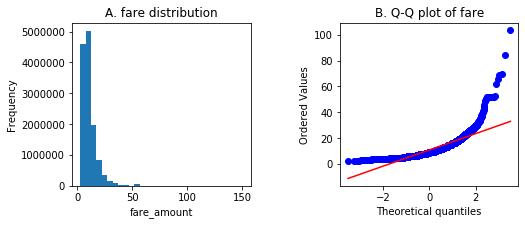

In [14]:
# Plot fare percentage distribution
fig, ax = plt.subplots(1,2,figsize=(8,3))
fig.subplots_adjust(wspace=.5)

ax[0].hist(df['fare_amount'], bins=30)
ax[0].set(xlabel='fare_amount ($)', ylabel='Number of trips');

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('fare_amount')
ax[0].set_title('A. fare distribution')

stats.probplot(df['fare_amount'].sample(3000), dist="norm", plot=ax[1])
ax[1].set_title('B. Q-Q plot of fare')

print("Skewness: %f" % df['fare_amount'].skew())
print("Kurtosis: %f" % df['fare_amount'].kurt())
#fig.savefig('fig7.svg', format='svg',bbox_inches='tight')

print('The average fare is',round(df['fare_amount'].mean(),1),', the standard deviation is',round(df['fare_amount'].std(),1))
print('The median fare is',round(df['fare_amount'].median(),1),', the 95% of fare fell between',
      round(df['fare_amount'].quantile(.025),2),'to',round(df['fare_amount'].quantile(.975), 1))

The distribution of the tip percentage is shown above. Overall, the tip percentage do not follow a normal distribution, and is centered around a few typical values

In [15]:
# Import necessary libraries to build model
from  sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
import xgboost as xgb

In [16]:
to_drop1 = ['store_and_fwd_flag', 'pickup_datetime', 'payment_type', 
           'dropoff_datetime', 'medallion', 'hack_license', 'pickup_latitude', 'dropoff_latitude',
            'pickup_longitude', 'dropoff_longitude', 'pickup_borough','dropoff_borough', 'pickup_airport', 
            'dropoff_airport', 'trip_geodistance', 'trip_time_in_secs', 'tip_amount', 'total_amount', 'trip_logdist']

In [17]:
df_fare = df[df.columns.difference(to_drop1)]

In [18]:
# create dummy variables
df_fare_dummies = pd.get_dummies(df_fare, columns=['pickup_day','passenger_range','speed_range',
                                   'pickup_origin','dropoff_dest', 'pickup_day_type', 'rate_code', 'vendor_id']
                     )

In [19]:
to_drop2 = ['pickup_day_type', 'dropoff_day_type', 'dropoff_day', 'pickup_day']

In [20]:
df_fare2 =df_fare_dummies[df_fare_dummies.columns.difference(to_drop2)]

In [21]:
df_fare2 = df_fare2

In [22]:
df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'pickup_datetime',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'rate_code', 'store_and_fwd_flag',
       'dropoff_datetime', 'passenger_count', 'trip_time_in_secs',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_borough',
       'dropoff_borough', 'pickup_airport', 'dropoff_airport',
       'trip_duration_hour', 'dropoff_hour', 'pickup_hour', 'pickup_day_date',
       'dropoff_day_date', 'pickup_day', 'dropoff_day', 'trip_logdist',
       'trip_speed', 'trip_geodistance', 'pickup_day_type', 'dropoff_day_type',
       'pickup_origin', 'dropoff_dest', 'trip_duration_min', 'passenger_range',
       'speed_range'],
      dtype='object')

In [23]:
predict_cols= ['trip_duration_min', 'trip_distance', 'pickup_origin_Newark_Airport', 'pickup_origin_LaGuardia_Airport',
       'pickup_origin_bronx', 'pickup_origin_brooklyn', 'pickup_origin_JFK_Airport',
       'pickup_origin_manhattan', 'pickup_origin_queens',
       'pickup_origin_staten_island', 'dropoff_dest_Newark_Airport',
       'dropoff_dest_bronx', 'dropoff_dest_brooklyn', 'dropoff_dest_manhattan',
       'dropoff_dest_queens', 'dropoff_dest_staten_island', 'pickup_hour',
       'pickup_day_Friday', 'pickup_day_Monday', 'pickup_day_Saturday',
       'pickup_day_Sunday', 'pickup_day_Thursday', 'pickup_day_Tuesday',
       'pickup_day_Wednesday']

X = df_fare_dummies[predict_cols]

In [24]:
df_fare3 = df_fare2.sample(n = 1000000)

In [25]:
X = df_fare3.drop(['fare_amount'], axis = 1)

In [26]:
X.to_pickle('X variables for fare model.pickle')

In [27]:
y = df_fare3['fare_amount']

X = pd.read_pickle('X variables for fare model.pickle')

y = pd.read_pickle('y variable for fare model.pickle')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .3)

In [29]:
lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.9634590127454908
0.9622933279572394


In [30]:
y_pred = lm.predict(X_test)
lrmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
lrmse

1.3481990172173224

In [32]:
#Defining MAPE function
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [33]:
mape(y_pred, y_test)

4.659659944948303

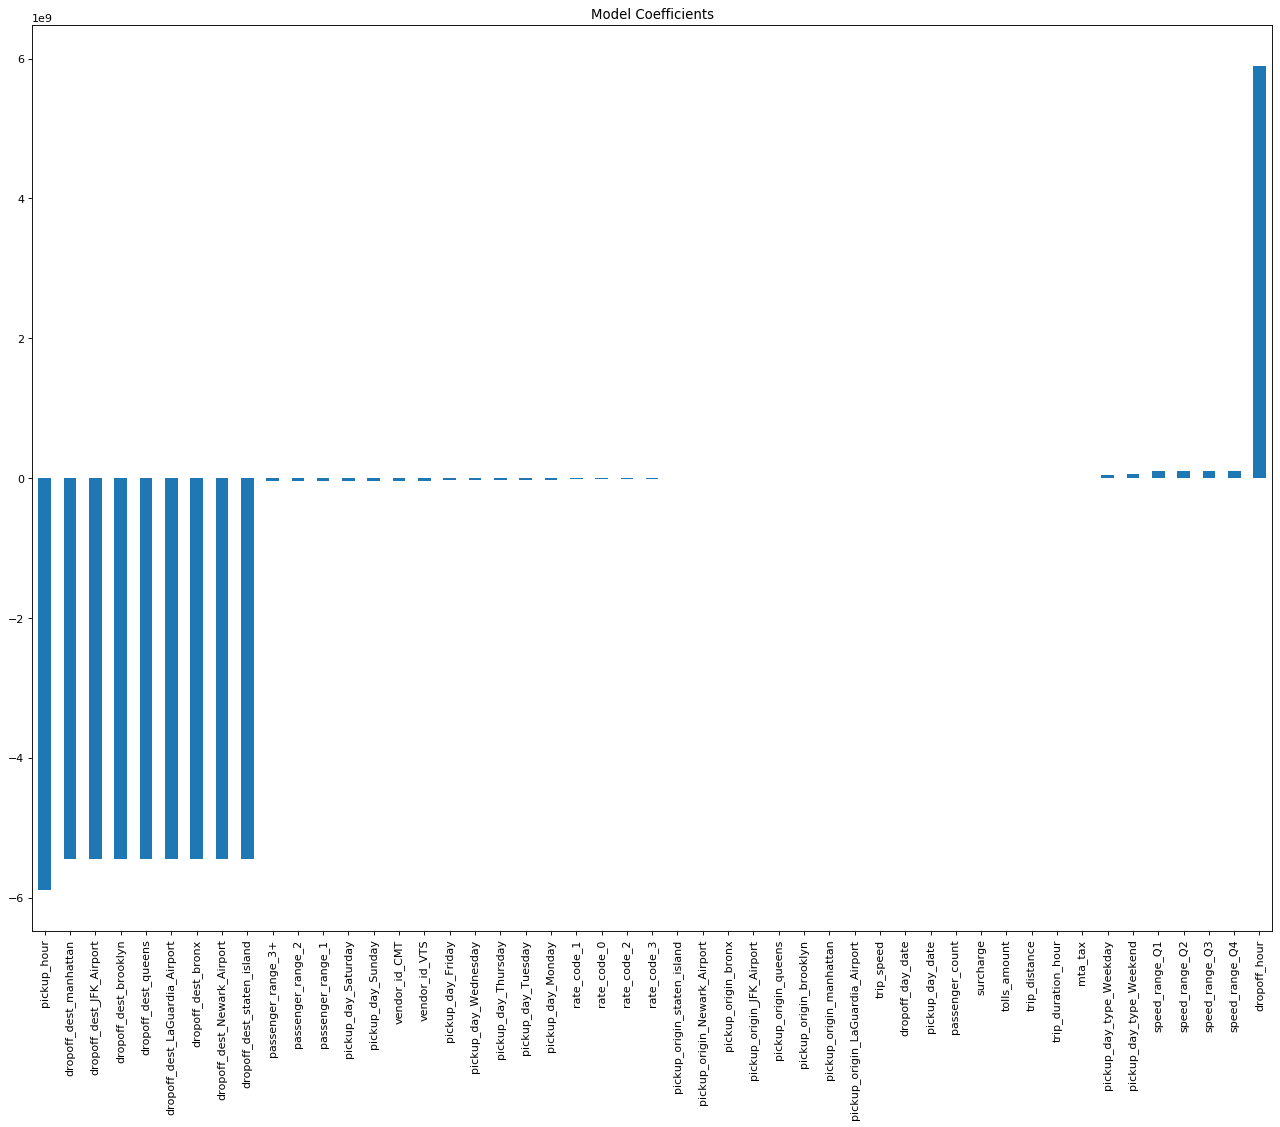

In [59]:
from matplotlib.pyplot import figure

coef1 = pd.Series(lm.coef_, X.columns).sort_values()
from matplotlib.pyplot import figure

figure(figsize=(20, 15), dpi=80)
coef1.plot(kind='bar', title='Model Coefficients')


In [60]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(random_state=42)
randomForest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [61]:
from  sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
import xgboost as xgb

In [62]:
randomForestPredict = randomForest.predict(X_test)
randomForest_mse = mean_squared_error(y_test, randomForestPredict)
randomForestMSE = np.sqrt(randomForest_mse)
randomForestMSE

0.7124045158559502

In [63]:
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)

In [64]:
randomForestImproved = model.fit(X_train,y_train)

In [65]:
randomForestImprovedPredict = randomForestImproved.predict(X_test)
randomForestImproved_mse = mean_squared_error(y_test, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
randomForestImprovedMSE

0.7957783796039305

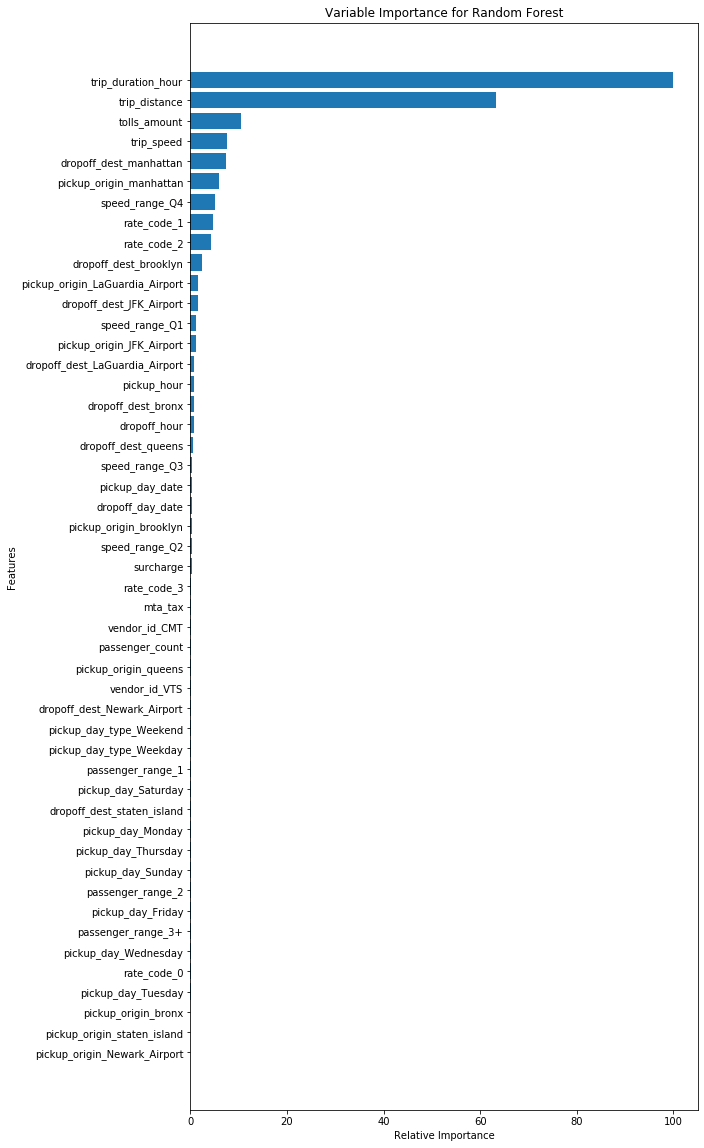

In [66]:
feature_importance = randomForestImproved.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()

In [67]:

from sklearn.ensemble import GradientBoostingRegressor
model_gradient= GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=3, random_state=0)
gradientBoost = model_gradient.fit(X_train, y_train)

In [68]:
predicted = model_gradient.predict(X_test)

In [69]:
grmse = np.sqrt(metrics.mean_squared_error(predicted, y_test))
grmse

0.7515326043802657

In [70]:
regression = pd.DataFrame({"regression": ['Multi Linear Regression','Random Forest', 'Improved Random Forest', 'Gradient Boosting Regrssion'], "rmse": [lrmse,randomForestMSE,randomForestImprovedMSE,grmse]},columns = ['regression','rmse'])

In [71]:
regression = regression.sort_values(by='rmse', ascending = False)

Text(0.5, 1.0, 'Comparing the different types of Regressions used')

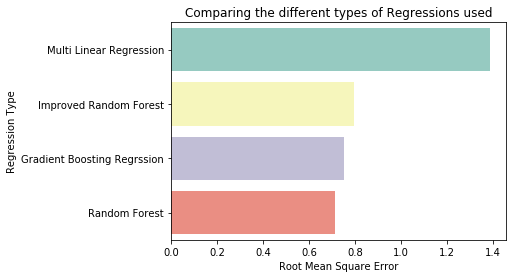

In [72]:
sns.barplot(regression['rmse'], regression['regression'], palette = 'Set3')
plt.xlabel("Root Mean Square Error")
plt.ylabel('Regression Type')
plt.title('Comparing the different types of Regressions used')

In [ ]:
lm.to_pickle('linreg_model_ver_2.pickle')

In [ ]:
#alg2 = LinearRegression(normalize=True)
#y_pred=modelfit(lm, X_train, X_test, predictor_cols,target_col)
coef1 = pd.Series(lm.coef_, X.columns).sort_values()

from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

coef1.plot(kind='bar', title='Model Coefficients')

In [ ]:
X_train.columns

In [ ]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(random_state=42)
randomForest.fit(X_train, y_train)

In [ ]:
randomForestPredict = randomForest.predict(X_test)
randomForest_mse = mean_squared_error(y_test, randomForestPredict)
randomForestMSE = np.sqrt(randomForest_mse)
randomForestMSE

In [ ]:
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)

In [ ]:
randomForestImproved = model.fit(X_train,y_train)

In [ ]:
randomForestImprovedPredict = randomForestImproved.predict(X_test)
randomForestImproved_mse = mean_squared_error(y_test, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
randomForestImprovedMSE

In [ ]:
feature_importance = randomForestImproved.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()